In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def SIR(t, x, beta_a, gamma_a):
    S, I, R = x
    dSdt = -beta_a * S * I
    dIdt = beta_a * S * I - gamma_a * I
    dRdt = gamma_a * I
    return [dSdt, dIdt, dRdt]

def model(t, x):
    S1, S2, I1, I2, R1, R2 = x
    beta = 0.5
    gamma = 0.1
    theta1 = 1
    theta2 = 2
    Im = I1 + I2
    a1 = min(max((theta1 * Im * beta) / 2, 0), 1)
    a2 = min(max((theta2 * Im * beta) / 2, 0), 1)
    dS1dt = -S1*S2 - S1*R2 - S1*I1*beta*(1-a1) - S1*I2*beta*(1-a1) - S1*I2*(1-beta*(1-a1)) + S1*S2 + S2*R1 + S2*I1*(1-beta*(1-a2))
    dS2dt = -S2*S1 - S2*R1 - S2*I1*beta*(1-a2) - S2*I1*(1-beta*(1-a2)) - S2*I2*beta*(1-a2) + S1*S2 + S1*R2 + S1*I2*(1-beta*(1-a1))
    dI1dt = -I1*S1*gamma - I1*S2*gamma - I1*S2*(1-gamma) - I1*I1*gamma - I1*I2*gamma - I1*I2*(1-gamma) - I1*R1*gamma - I1*R2*gamma - I1*R2*(1-gamma) + I2*S1*(1-gamma) + I2*I1*(1-gamma) + I2*R1*(1-gamma) + S1*I1*beta*(1-a1) + S2*I1*beta*(1-a2)   
    dI2dt = -I2*S1*gamma - I2*S2*gamma - I2*S1*(1-gamma) - I2*I1*gamma - I2*I2*gamma - I2*I1*(1-gamma) - I2*R1*gamma - I2*R2*gamma - I2*R1*(1-gamma) + I1*S2*(1-gamma) + I1*I2*(1-gamma) + I1*R2*(1-gamma) + S1*I2*beta*(1-a1) + S2*I2*beta*(1-a2)
    dR1dt = -R1*S2 - R1*I2 - R1*R2 + R2*S1 + R2*I1 + R2*R1 + I1*S1*gamma + I1*I1*gamma + I1*R1*gamma + I2*S1*gamma + I2*I1*gamma + I2*R1*gamma
    dR2dt = -R2*S1 - R2*I1 - R2*R1 + R1*S2 + R1*I2 + R1*R2 + I1*S2*gamma + I1*I2*gamma + I1*R2*gamma + I2*S2*gamma + I2*I2*gamma + I2*R2*gamma
    return [dS1dt, dS2dt, dI1dt, dI2dt, dR1dt, dR2dt]

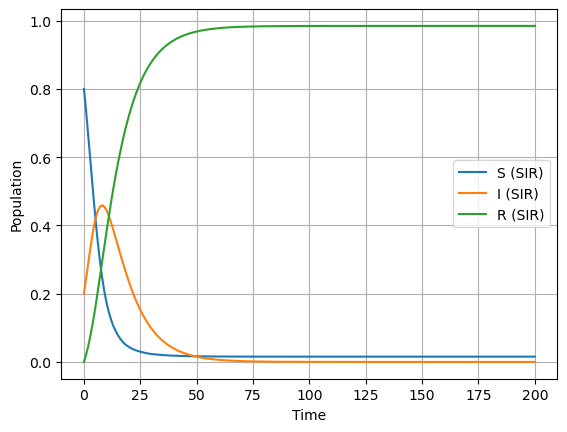

In [19]:
def SIR(t, x):
    S, I, R = x
    dSdt = -0.4 * S * I
    dIdt = 0.4 * S * I - 0.1 * I
    dRdt = 0.1 * I
    return [dSdt, dIdt, dRdt]

x0_SIR = [0.8, 0.2, 0.0] 
t_span = (0, 200)
t_eval = np.linspace(0, 200, 200)
sol_SIR = solve_ivp(SIR, t_span, x0_SIR, t_eval=t_eval)
plt.plot(sol_SIR.t, sol_SIR.y[0], label='S (SIR)')
plt.plot(sol_SIR.t, sol_SIR.y[1], label='I (SIR)')
plt.plot(sol_SIR.t, sol_SIR.y[2], label='R (SIR)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.show()

In [3]:
def objective(para):
    
    beta_a, gamma_a = para
    x0_SIR = [0.8, 0.2, 0.0] 
    x0_model = [0.4, 0.4, 0.1, 0.1, 0.0, 0.0]  
    t_span = (0, 200)
    t_eval = np.linspace(0, 200, 200)
    sol_SIR = solve_ivp(SIR, t_span, x0_SIR, args=(beta_a, gamma_a), t_eval=t_eval)
    sol_model = solve_ivp(model, t_span, x0_model, t_eval=t_eval)
    S_m = sol_model.y[0] + sol_model.y[1]
    I_m = sol_model.y[2] + sol_model.y[3]
    R_m = sol_model.y[4] + sol_model.y[5]
    sol_model_all = np.array([S_m, I_m, R_m])
    error = np.linalg.norm(sol_SIR.y - sol_model_all)
    
    return error

In [4]:
initial_values = [0.5, 0.1]

In [5]:
result = minimize(objective, initial_values,bounds=[(0, 1), (0, 1)])

In [6]:
beta_opt, gamma_opt = result.x

In [7]:
result.x

array([0.43265506, 0.10007239])

In [8]:
t_eval = np.linspace(0, 200, 200)
x0_SIR = [0.8, 0.2, 0.0]
x0_model = [0.4, 0.4, 0.1, 0.1, 0.0, 0.0]
sol_SIR_opt = solve_ivp(SIR, (0, 200), x0_SIR, args=(beta_opt, gamma_opt), t_eval=t_eval)
sol_model_opt = solve_ivp(model, (0, 200), x0_model, t_eval=t_eval)
S_opt = sol_model_opt.y[0] + sol_model_opt.y[1]
I_opt = sol_model_opt.y[2] + sol_model_opt.y[3]
R_opt = sol_model_opt.y[4] + sol_model_opt.y[5]

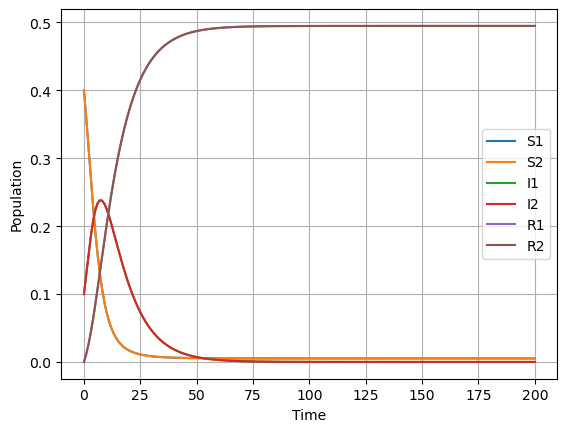

In [9]:
plt.plot(sol_model_opt.t, sol_model_opt.y[0], label='S1')
plt.plot(sol_model_opt.t, sol_model_opt.y[1], label='S2')
plt.plot(sol_model_opt.t, sol_model_opt.y[2], label='I1')
plt.plot(sol_model_opt.t, sol_model_opt.y[3], label='I2')
plt.plot(sol_model_opt.t, sol_model_opt.y[4], label='R1')
plt.plot(sol_model_opt.t, sol_model_opt.y[5], label='R2')
plt.xlabel('Time')
plt.ylabel('Population')
plt.grid()
plt.legend()
plt.show()

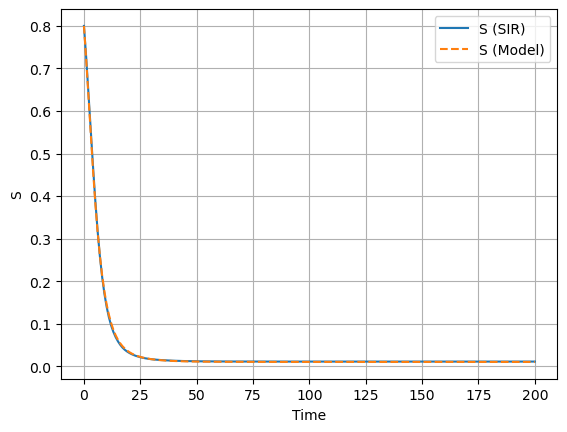

In [10]:
plt.plot(sol_SIR_opt.t, sol_SIR_opt.y[0], label='S (SIR)')
plt.plot(sol_model_opt.t, S_opt, '--', label='S (Model)')
plt.xlabel('Time')
plt.ylabel('S')
plt.legend()
plt.grid()
plt.show()

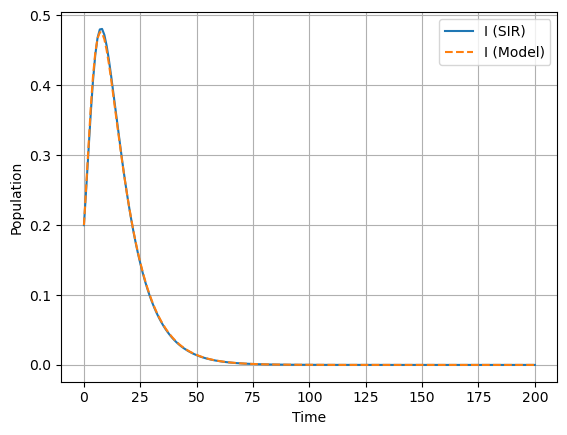

In [11]:
plt.plot(sol_SIR_opt.t, sol_SIR_opt.y[1], label='I (SIR)')
plt.plot(sol_model_opt.t, I_opt, '--', label='I (Model)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.show()

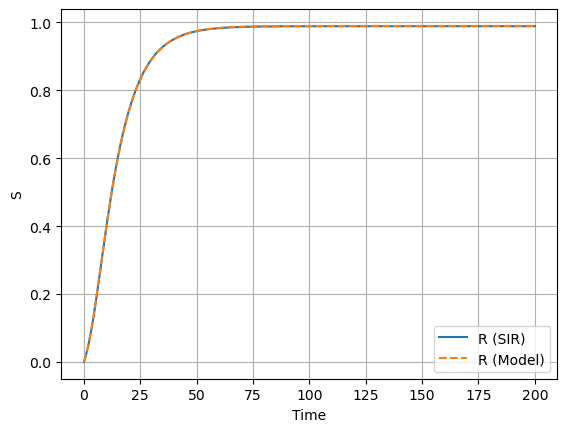

In [12]:
plt.plot(sol_SIR_opt.t, sol_SIR_opt.y[2], label='R (SIR)')
plt.plot(sol_model_opt.t, R_opt, '--', label='R (Model)')
plt.xlabel('Time')
plt.ylabel('S')
plt.legend()
plt.grid()
plt.show()

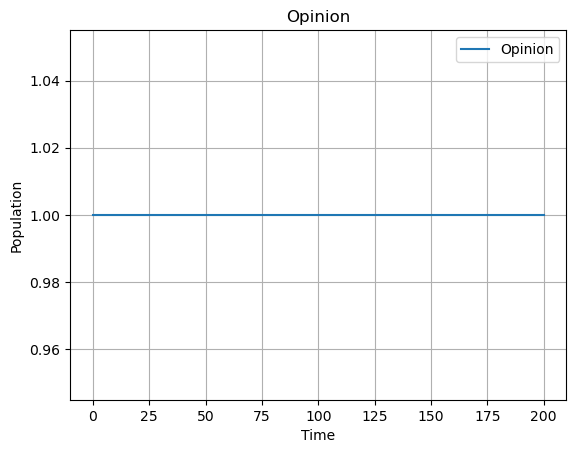

In [13]:
plt.plot(sol_model_opt.t, sol_model_opt.y[0] + sol_model_opt.y[2] + sol_model_opt.y[4] + sol_model_opt.y[1] + sol_model_opt.y[3] + sol_model_opt.y[5], label='Opinion')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Opinion')
plt.grid()
plt.show()

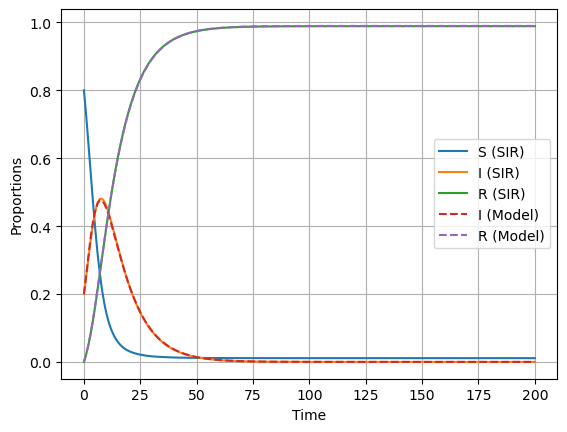

In [14]:
plt.plot(t_eval, sol_SIR_opt.y[0], label='S (SIR)', linestyle='solid')
plt.plot(t_eval, sol_SIR_opt.y[1], label='I (SIR)', linestyle='solid')
plt.plot(t_eval, sol_SIR_opt.y[2], label='R (SIR)', linestyle='solid')
plt.plot(t_eval, I_opt, label='I (Model)', linestyle='dashed')
plt.plot(t_eval, R_opt, label='R (Model)', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Proportions')
plt.legend()
plt.grid()
plt.show()

## Error According to Beta and Gamma

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [14]:
def SIR(t, x):
    beta_a = 0.4
    gamma_a = 0.1
    S, I, R = x
    dSdt = -beta_a * S * I
    dIdt = beta_a * S * I - gamma_a * I
    dRdt = gamma_a * I
    return [dSdt, dIdt, dRdt]

def model(t, x, beta, gamma, theta1, theta2):
    S1, S2, I1, I2, R1, R2 = x
    Im = I1 + I2
    a1 = min(max((theta1 * Im * beta) / 2, 0), 1)
    a2 = min(max((theta2 * Im * beta) / 2, 0), 1)
    dS1dt = -S1*S2 - S1*R2 - S1*I1*beta*(1-a1) - S1*I2*beta*(1-a1) - S1*I2*(1-beta*(1-a1)) + S1*S2 + S2*R1 + S2*I1*(1-beta*(1-a2))
    dS2dt = -S2*S1 - S2*R1 - S2*I1*beta*(1-a2) - S2*I1*(1-beta*(1-a2)) - S2*I2*beta*(1-a2) + S1*S2 + S1*R2 + S1*I2*(1-beta*(1-a1))
    dI1dt = -I1*S1*gamma - I1*S2*gamma - I1*S2*(1-gamma) - I1*I1*gamma - I1*I2*gamma - I1*I2*(1-gamma) - I1*R1*gamma - I1*R2*gamma - I1*R2*(1-gamma) + I2*S1*(1-gamma) + I2*I1*(1-gamma) + I2*R1*(1-gamma) + S1*I1*beta*(1-a1) + S2*I1*beta*(1-a2)   
    dI2dt = -I2*S1*gamma - I2*S2*gamma - I2*S1*(1-gamma) - I2*I1*gamma - I2*I2*gamma - I2*I1*(1-gamma) - I2*R1*gamma - I2*R2*gamma - I2*R1*(1-gamma) + I1*S2*(1-gamma) + I1*I2*(1-gamma) + I1*R2*(1-gamma) + S1*I2*beta*(1-a1) + S2*I2*beta*(1-a2)
    dR1dt = -R1*S2 - R1*I2 - R1*R2 + R2*S1 + R2*I1 + R2*R1 + I1*S1*gamma + I1*I1*gamma + I1*R1*gamma + I2*S1*gamma + I2*I1*gamma + I2*R1*gamma
    dR2dt = -R2*S1 - R2*I1 - R2*R1 + R1*S2 + R1*I2 + R1*R2 + I1*S2*gamma + I1*I2*gamma + I1*R2*gamma + I2*S2*gamma + I2*I2*gamma + I2*R2*gamma
    return [dS1dt, dS2dt, dI1dt, dI2dt, dR1dt, dR2dt]

def objective(beta, gamma, theta1, theta2):
    x0_SIR = [0.8, 0.2, 0.0] 
    x0_model = [0.4, 0.4, 0.1, 0.1, 0.0, 0.0]  
    t_span = (0, 200)
    t_eval = np.linspace(0, 200, 200)
    sol_SIR = solve_ivp(SIR, t_span, x0_SIR, t_eval=t_eval)  
    sol_model = solve_ivp(model, t_span, x0_model, args=(beta, gamma, theta1, theta2), t_eval=t_eval)
    S_m = sol_model.y[0] + sol_model.y[1]
    I_m = sol_model.y[2] + sol_model.y[3]
    R_m = sol_model.y[4] + sol_model.y[5]
    sol_model_all = np.array([S_m, I_m, R_m])
    error = np.linalg.norm(sol_SIR.y - sol_model_all)
    
    return error

beta_vals = np.linspace(0.1, 0.5, 5)
gamma_vals = np.linspace(0.1, 0.5, 5)
theta1_vals = np.linspace(0.5, 2.0, 5)
theta2_vals = np.linspace(0.5, 2.0, 5)

errors = np.zeros((len(beta_vals), len(gamma_vals), len(theta1_vals), len(theta2_vals)))

for i, beta in enumerate(beta_vals):
    for j, gamma in enumerate(gamma_vals):
        for k, theta1 in enumerate(theta1_vals):
            for l, theta2 in enumerate(theta2_vals):
                error_grid[i, j, k, l] = objective(beta, gamma, theta1, theta2)
#                 r2_grid[i ,j ,k ,l] = r2_score(sol_SIR.y[0], sol_model.y[0] + sol_model.y[1])

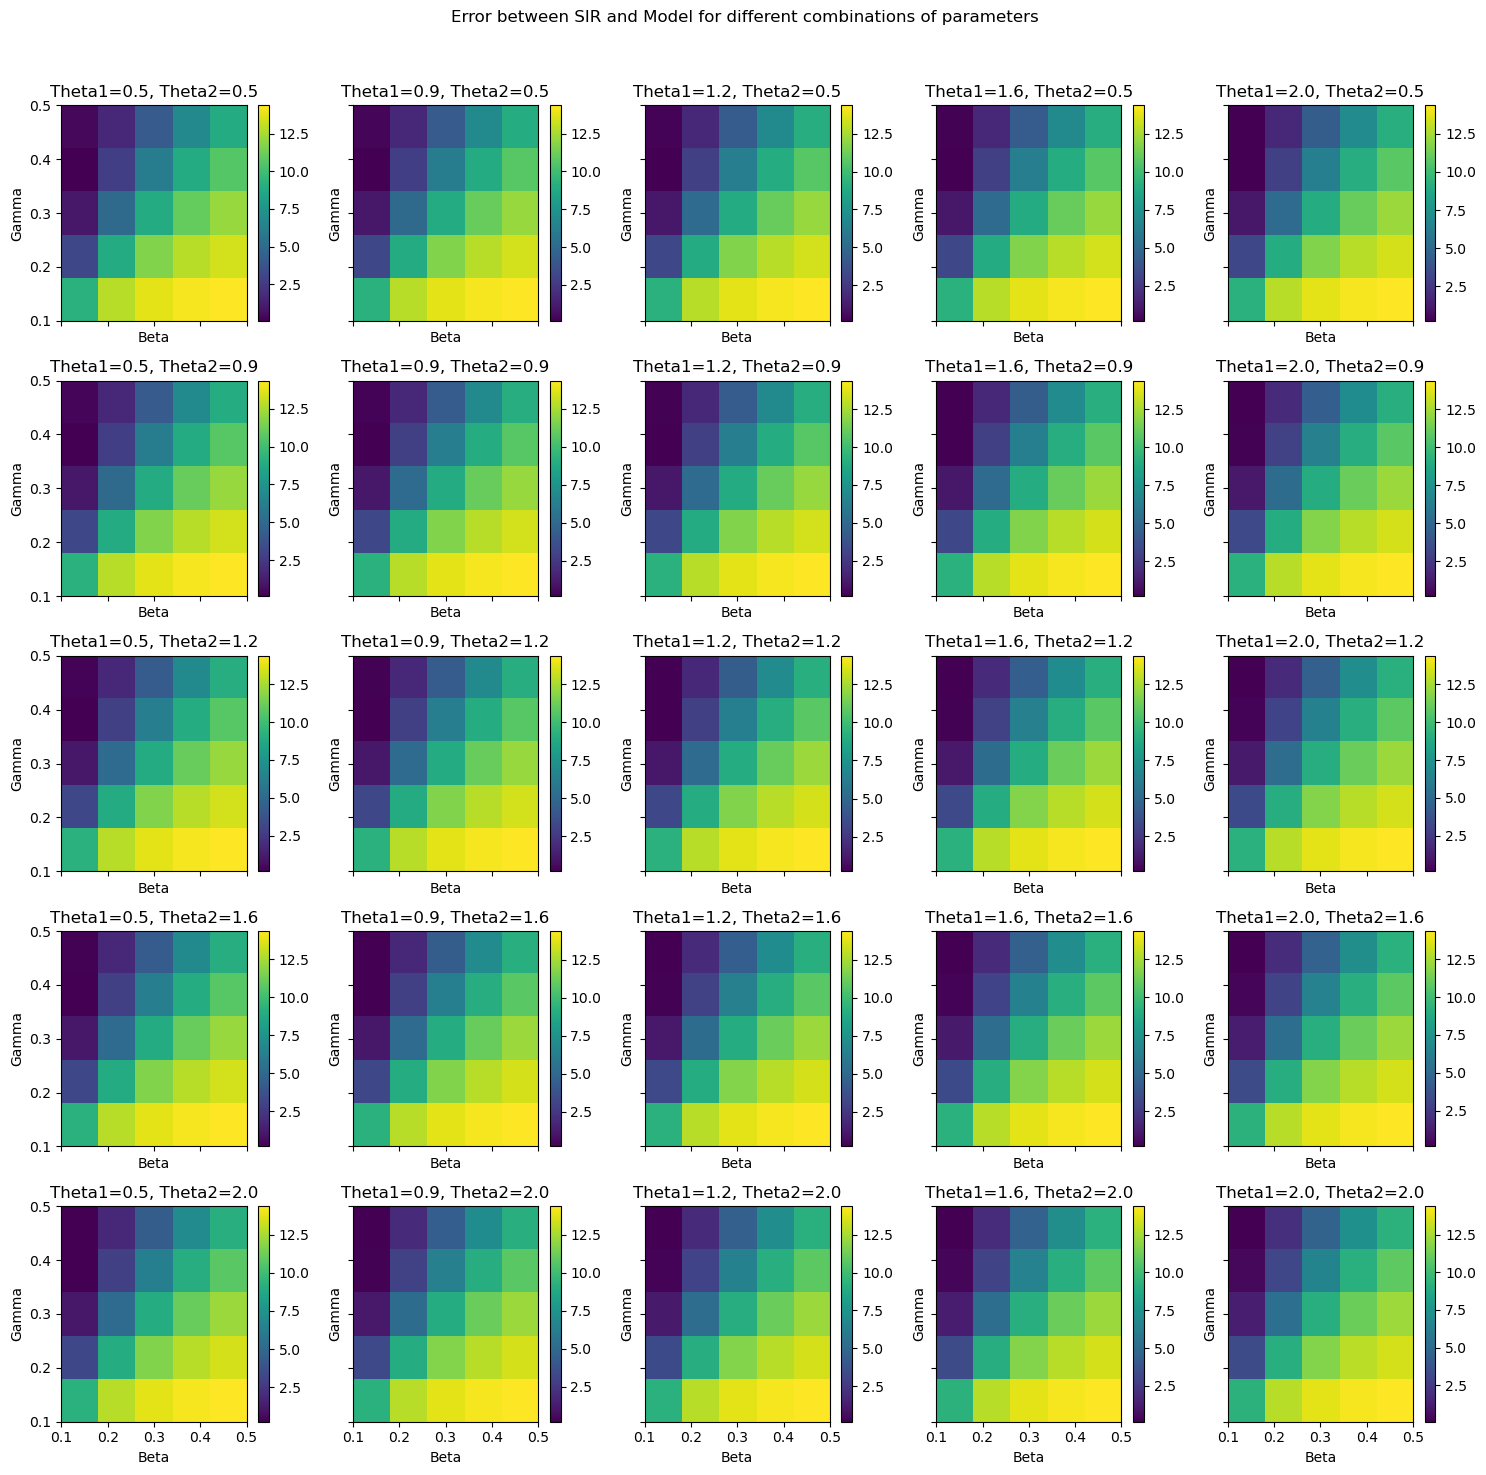

In [15]:
# Plot the error using a series of 2D heatmaps
fig, axes = plt.subplots(len(theta2_vals), len(theta1_vals), figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Error between SIR and Model for different combinations of parameters')

for k, theta1 in enumerate(theta1_vals):
    for l, theta2 in enumerate(theta2_vals):
        ax = axes[l, k]
        c = ax.imshow(errors[:, :, k, l], cmap='viridis', origin='lower', aspect='auto',
                      extent=[beta_vals[0], beta_vals[-1], gamma_vals[0], gamma_vals[-1]])
        ax.set_title(f'Theta1={theta1:.1f}, Theta2={theta2:.1f}')
        ax.set_xlabel('Beta')
        ax.set_ylabel('Gamma')
        fig.colorbar(c, ax=ax)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
x0_SIR = [0.8, 0.2, 0.0] 
x0_model = [0.4, 0.4, 0.1, 0.1, 0.0, 0.0]  
t_span = (0, 200)
t_eval = np.linspace(0, 200, 200)
sol_SIR = solve_ivp(SIR, t_span, x0_SIR, t_eval=t_eval)
sol_model = solve_ivp(model, t_span, x0_model, args=(beta, gamma, theta1, theta2), t_eval=t_eval)
r2 = r2_score(sol_SIR.y[0], sol_model.y[0] + sol_model.y[1])

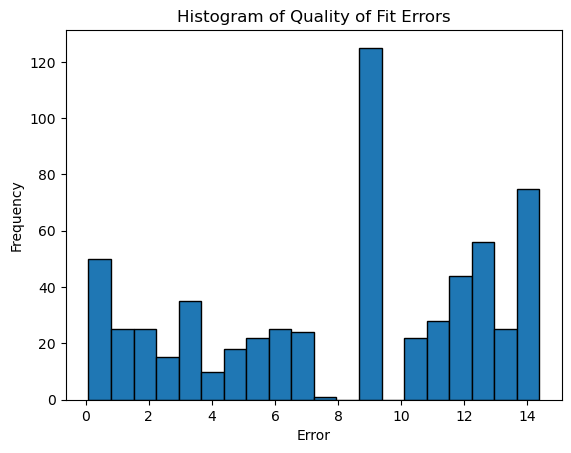

(625,)

In [26]:
flat_errors = errors.flatten()
plt.hist(flat_errors, bins=20, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Quality of Fit Errors')
plt.show()

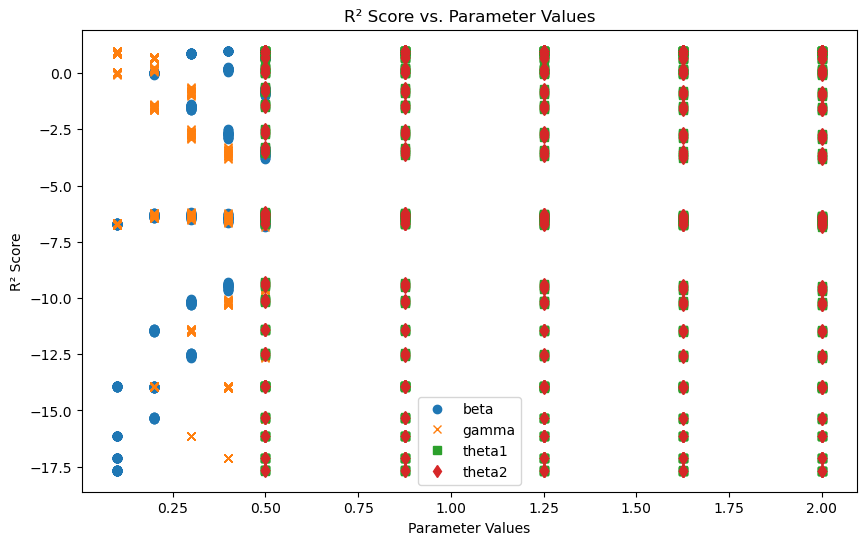

In [27]:
def calculate_r2_score(beta, gamma, theta1, theta2):
    x0_SIR = [0.8, 0.2, 0.0]
    x0_model = [0.4, 0.4, 0.1, 0.1, 0.0, 0.0]
    t_span = (0, 200)
    t_eval = np.linspace(0, 200, 200)
    
    # Solve the SIR model
    sol_SIR = solve_ivp(SIR, t_span, x0_SIR, t_eval=t_eval)
    
    # Solve the other model
    sol_model = solve_ivp(model, t_span, x0_model, args=(beta, gamma, theta1, theta2), t_eval=t_eval)
    
    # Aggregate S, I, R from the model
    S_m = sol_model.y[0] + sol_model.y[1]
    I_m = sol_model.y[2] + sol_model.y[3]
    R_m = sol_model.y[4] + sol_model.y[5]
    
    # Calculate R² score for each component
    r2_S = r2_score(sol_SIR.y[0], S_m)
    r2_I = r2_score(sol_SIR.y[1], I_m)
    r2_R = r2_score(sol_SIR.y[2], R_m)
    
    # Return the average R² score
    return (r2_S + r2_I + r2_R) / 3

# Define the parameter values
beta_vals = np.linspace(0.1, 0.5, 5)
gamma_vals = np.linspace(0.1, 0.5, 5)
theta1_vals = np.linspace(0.5, 2.0, 5)
theta2_vals = np.linspace(0.5, 2.0, 5)

# Initialize the R² score grid
r2_scores = np.zeros((len(beta_vals), len(gamma_vals), len(theta1_vals), len(theta2_vals)))

# Calculate the R² score for each combination of parameter values
for i, beta in enumerate(beta_vals):
    for j, gamma in enumerate(gamma_vals):
        for k, theta1 in enumerate(theta1_vals):
            for l, theta2 in enumerate(theta2_vals):
                r2_scores[i, j, k, l] = calculate_r2_score(beta, gamma, theta1, theta2)

# Flatten the R² scores and corresponding parameter values for plotting
flat_r2_scores = r2_scores.flatten()
flat_params = np.array([(beta, gamma, theta1, theta2) 
                        for beta in beta_vals 
                        for gamma in gamma_vals 
                        for theta1 in theta1_vals 
                        for theta2 in theta2_vals])

# Plot the R² scores
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(flat_params[:, 0], flat_r2_scores, 'o', label='beta')
ax.plot(flat_params[:, 1], flat_r2_scores, 'x', label='gamma')
ax.plot(flat_params[:, 2], flat_r2_scores, 's', label='theta1')
ax.plot(flat_params[:, 3], flat_r2_scores, 'd', label='theta2')
ax.set_xlabel('Parameter Values')
ax.set_ylabel('R² Score')
ax.legend()
plt.title('R² Score vs. Parameter Values')
plt.show()